CSS - Final Project

In [66]:
import json, re, glob
import pandas as pd
import networkx as nx
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
import glob, json, os
from tqdm import tqdm
import nltk
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/Magnus/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Magnus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Motivation

We choose to explore a premade dataset of US congress tweets, consisting of tweets from about 2200 accounts over 5 years. This dataset was appealing to us because of how polarized and heated the political scene in the US can get, as seen for example in the latest election. Through this project we wanted to create and analyse a network based on sentiment between accounts, to get a better understanding of the dynamics within and between parties. As well as, trying to identify any patterns or sources of positive or negative sentiment. We hope this analysis will provide some informative insight into the interesting world of US congress tweets. 

In [67]:
data_dir = "../congresstweets/data"

print("Looking in:", data_dir)
print("Contents:", os.listdir(data_dir)[:5])

json_paths = glob.glob(os.path.join(data_dir, "*.json"))
print(f"Found {len(json_paths)} JSON files")

tweets = []
for path in tqdm(json_paths):
    with open(path, "r", encoding="utf-8") as f:
        tweets.extend(json.load(f))

df = pd.DataFrame(tweets)
print(f"Loaded {len(df)} tweets")
df.head()


Looking in: ../congresstweets/data
Contents: ['2019-11-21.json', '2022-04-11.json', '2020-11-18.json', '2019-01-21.json', '2020-01-18.json']
Found 2197 JSON files


100%|██████████| 2197/2197 [00:27<00:00, 79.57it/s] 


Loaded 5068352 tweets


,id,screen_name,user_id,time,link,text,source,yesterday,today
0,1197531273473994755,RepValDemings,798973032362606600,2019-11-21T10:04:39-05:00,https://www.twitter.com/RepValDemings/statuses...,President Trump demanded that Ukraine interfer...,Twitter Web App,NaN,NaN
1,1197574591130013700,SenatorLeahy,242836537,2019-11-21T12:56:47-05:00,https://www.twitter.com/SenatorLeahy/statuses/...,Yes. He was the soul and patron saint of snowb...,TweetDeck,NaN,NaN
2,1197605237969866752,RepJayapal,815733290955112448,2019-11-21T14:58:33-05:00,https://www.twitter.com/RepJayapal/statuses/11...,"This violence is predictable and preventable, ...",Twitter Web App,NaN,NaN
3,1197611392427286540,JackieSpeier,521731529,2019-11-21T15:23:01-05:00,https://www.twitter.com/JackieSpeier/statuses/...,"Last week, my legislation removing the deadlin...",Sprout Social,NaN,NaN
4,1197706911375863808,SenCoryGardner,235217558,2019-11-21T21:42:34-05:00,https://www.twitter.com/SenCoryGardner/statuse...,Now they want to do the same with corporations...,Twitter Web App,NaN,NaN


In [ ]:
# Create a metadata mapping to add to network later
# Downloaded from congresstweets-automator repo
meta_path = "../congresstweets/historical-users-filtered.json"

with open(meta_path, "r") as f:
    users = json.load(f)

# Build map: {screen_name: party}
party_map = {
    u['accounts'][0]["screen_name"].lower(): u.get("party", None)
    for u in users
    if "party" in u
}
chamber_map = {
    u['accounts'][0]["screen_name"].lower(): u.get("chamber", None)
    for u in users
    if "party" in u
}

In [ ]:
def mention_context_sentiment(text, handle, window_size=10):
    """
    For each @handle in `text`, pull out up to `window_size` words
    before and after, run VADER on that slice, and average.
    """
    # Clean the handle
    handle_clean = handle.lower().lstrip('@')
    # Compile a regex that gets up to window_size words on each side, \S+ matches a "word"
    pattern = re.compile(
        rf'(?:\S+\s+){{0,{window_size}}}@{re.escape(handle_clean)}(?:\s+\S+){{0,{window_size}}}',
        flags=re.IGNORECASE
    )
    scores = []
    for m in pattern.finditer(text):
        ctx = m.group(0)
        scores.append(analyzer.polarity_scores(ctx)['compound'])
    return sum(scores) / len(scores) if scores else 0.0

In [71]:
SAMPLE_SIZE = 300_000
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).reset_index(drop=True)
print(f"Working on {len(df_sample):,} tweets (out of {len(df):,})")

mention_re = re.compile(r"@([A-Za-z0-9_]+)")

G = nx.DiGraph()
for screen_name, text in tqdm(zip(df_sample["screen_name"], df_sample["text"]), desc="Tweets processed", total = 300_000):
    mentions = set(m.lower() for m in mention_re.findall(text))
    src = screen_name.lower()
    for tgt in mentions:
        mention_sentiment = mention_context_sentiment(text, tgt)
        if tgt == src:
            continue
        if G.has_edge(src, tgt):
            G[src][tgt]["n_mentions"] += 1
            G[src][tgt]["avg_sentiment"] += mention_sentiment
        else:
            G.add_edge(src, tgt, n_mentions=1, avg_sentiment = mention_sentiment)

# Average sentiment values
for src, tgt in tqdm(G.edges(), desc='Averaging sentiments'): 
    G[src][tgt]['avg_sentiment'] = G[src][tgt]['avg_sentiment']/G[src][tgt]['n_mentions']
    
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
in_degs  = np.array([d for _, d in G.in_degree()])
out_degs = np.array([d for _, d in G.out_degree()])

print(f"Nodes: {num_nodes:,}")
print(f"Edges: {num_edges:,}")
print(f"In‑degree → mean: {in_degs.mean():.2f},  std: {in_degs.std():.2f}")
print(f"Out‑degree → mean: {out_degs.mean():.2f}, std: {out_degs.std():.2f}")

low_weight = [(u, v) for u, v, d in G.edges(data=True) if d["n_mentions"] < 3]
G.remove_edges_from(low_weight)
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

print(f"After pruning: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
in_degs  = np.array([d for _, d in G.in_degree()])
out_degs = np.array([d for _, d in G.out_degree()])
print(f"In‑degree → mean: {in_degs.mean():.2f},  std: {in_degs.std():.2f}")
print(f"Out‑degree → mean: {out_degs.mean():.2f}, std: {out_degs.std():.2f}")


Working on 300,000 tweets (out of 5,068,352)


Averaging sentiments: 100%|██████████| 177616/177616 [00:00<00:00, 752329.52it/s]


Nodes: 56,924
Edges: 177,616
In‑degree → mean: 3.12,  std: 12.68
Out‑degree → mean: 3.12, std: 31.54
After pruning: 5,358 nodes, 17,713 edges
In‑degree → mean: 3.31,  std: 13.49
Out‑degree → mean: 3.31, std: 13.35


In [72]:
# Add metadata to network
nx.set_node_attributes(G, party_map, name="party")
nx.set_node_attributes(G, chamber_map, name="chamber")

In [73]:
from collections import Counter
counts = Counter(nx.get_node_attributes(G, "party").values())
print(counts)

Counter({'D': 292, 'R': 268, 'N/A': 3, 'I': 2, 'L': 1})


In [74]:
# Extract (source, target, avg_sentiment) for all edges
edge_data = [(u, v, data.get('avg_sentiment', 0.0)) for u, v, data in G.edges(data=True)]
sent_df = pd.DataFrame(edge_data, columns=['source', 'target', 'avg_sentiment'])

# Sort to get extremes
sent_df_sorted = sent_df.sort_values('avg_sentiment')
neg_df = sent_df_sorted.head(5).reset_index(drop=True)
pos_df = sent_df_sorted.tail(5).sort_values('avg_sentiment', ascending=False).reset_index(drop=True)

print('5 Most Negative Sentiment Edges\n', neg_df)
print('\n5 Most Positive Sentiment Edges\n', pos_df)

5 Most Negative Sentiment Edges
            source           target  avg_sentiment
0     lacyclaymo1  socialpowerone1      -0.803100
1    nmalliotakis          bpunion      -0.748433
2  repandybiggsaz       bucksexton      -0.719500
3     appropsdems      replawrence      -0.698100
4    reppaultonko           cdcgov      -0.649100

5 Most Positive Sentiment Edges
            source           target  avg_sentiment
0   chrismurphyct       rexchapman       0.931233
1  repcarolmiller  woodywilliams45       0.917100
2       teamamash      steffi_cole       0.899000
3     timburchett  langford_stacey       0.867767
4       dinatitus    goldenknights       0.861550


In [75]:
sent_series = df_sample["text"].apply(analyzer.polarity_scores).apply(pd.Series)
df_sample = pd.concat([df_sample, sent_series], axis=1)


user_stats = (
    df_sample
    .groupby("screen_name")["compound"]
    .agg(["mean","median","std","count"])
    .reset_index()
)

user_stats.columns = [
    "screen_name",
    "avg_compound",
    "med_compound",
    "std_compound",
    "n_tweets"
]

print("Sample of per‐user sentiment stats:")
print(user_stats.head())


mapping_avg   = dict(zip(user_stats["screen_name"].str.lower(), user_stats["avg_compound"]))
mapping_count = dict(zip(user_stats["screen_name"].str.lower(), user_stats["n_tweets"]))

nx.set_node_attributes(G, mapping_avg,   "avg_sentiment_account")
nx.set_node_attributes(G, mapping_count, "n_tweets")

top5 = user_stats.nlargest(5, "avg_compound")[["screen_name","avg_compound","n_tweets"]]
bot5 = user_stats.nsmallest(5, "avg_compound")[["screen_name","avg_compound","n_tweets"]]
print("\nTop 5 happiest accounts:\n", top5.to_string(index=False))
print("\nTop 5 saddest accounts:\n", bot5.to_string(index=False))


Sample of per‐user sentiment stats:
    screen_name  avg_compound  med_compound  std_compound  n_tweets
0   ABrindisiNY      0.375948        0.5399      0.515374        25
1  ANTHONYDESPO      0.305815        0.6352      0.681033        59
2           AOC      0.229071        0.4019      0.595130       514
3   ASEANCaucus      0.487633        0.6158      0.462115         6
4    AaronPBean      0.658950        0.8468      0.443547         4

Top 5 happiest accounts:
     screen_name  avg_compound  n_tweets
     JenKiggans      0.962100         1
      johnthune      0.960600         1
MarchantforTX24      0.948500         1
  YadiraCaraveo      0.942600         2
 VanHollenForMD      0.934667         3

Top 5 saddest accounts:
    screen_name  avg_compound  n_tweets
 DeliaCRamirez       -0.7096         1
  RatcliffeTX4       -0.7003         1
 Votejimjordan       -0.4767         1
  VoteLouiseNY       -0.4588         1
AndreaRSalinas       -0.4404         1


In [76]:
# Color nodes based on average sentiment
color_map = {
    'negative': '#d62728',   # red
    'neutral':  '#7f7f7f',   # gray
    'positive': '#2ca02c'    # green
}
for k, v in G.nodes(data=True):
    if v:
        avg_sentiment = v['avg_sentiment_account']
    else: avg_sentiment = 0
    v['group'] = color_map['positive'] if avg_sentiment > 0.1 else color_map['negative'] if avg_sentiment < -0.1 else color_map['neutral']

KeyError: 'avg_sentiment_account'

In [78]:
# Color nodes based on political party
color_map = {
    'D': '#0078ff',    # Blue
    'R':  '#ff0000',   # Red
    'I': '#ecff00',   # Purple
    'L': '#4dff00',   # Green
    'N/A': '#7f7f7f'  # Grey
    
}
for k, v in G.nodes(data=True):
    if v:
        try:
            party = v['party']
        except: party = 'N/A'
    else: party = 'N/A'
    v['group'] = color_map[party]

In [79]:
def get_deg_assortativity_coef(G):
    degrees = dict(G.degree())
    N = len(G.edges())

    same_deg = 0
    for (i, j) in list(G.edges()): # Compute total amount of edges between nodes of equal degree
        if degrees[i] == degrees[j]:
            same_deg += 1/N

    degs = np.array(list(degrees.values()))
    exp_same_deg = 0
    total_half_stubs = sum(degs)
    for deg in set(degs): # Compute expected number of edges between nodes of same degree 
        n_deg = len(degs[degs == deg])
        n_half_stubs = n_deg*deg
        exp_same_deg += (n_half_stubs/total_half_stubs)**2

    r = (same_deg - exp_same_deg)/(1-exp_same_deg)
    return r

In [80]:
get_deg_assortativity_coef(G)

-0.01012482441275055

In [81]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import netwulf

network_properties, config = netwulf.visualize(G, plot_in_cell_below=False)
print('got data')

for link in network_properties['links']:
    src = link['source']   
    tgt = link['target'] 
    # Add avg sentiment back to link
    link['avg_sentiment'] = G[src][tgt]['avg_sentiment']

sents = [d['avg_sentiment'] for _,_,d in G.edges(data=True)]
cmap = cm.get_cmap('RdYlGn')
norm = mcolors.Normalize(vmin=min(sents), vmax=max(sents))

for link in network_properties['links']:
    s = link.get('avg_sentiment')
    rgba = cmap(norm(s))
    link['color'] = mcolors.to_hex(rgba)

# now instruct Netwulf to use your manual hexes
config['link_color_field'] = 'color'
# graph_data, config = netwulf.visualize(network_properties, config = config)

/opt/homebrew/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


got data


/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_44262/1779668827.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_44262/729509020.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


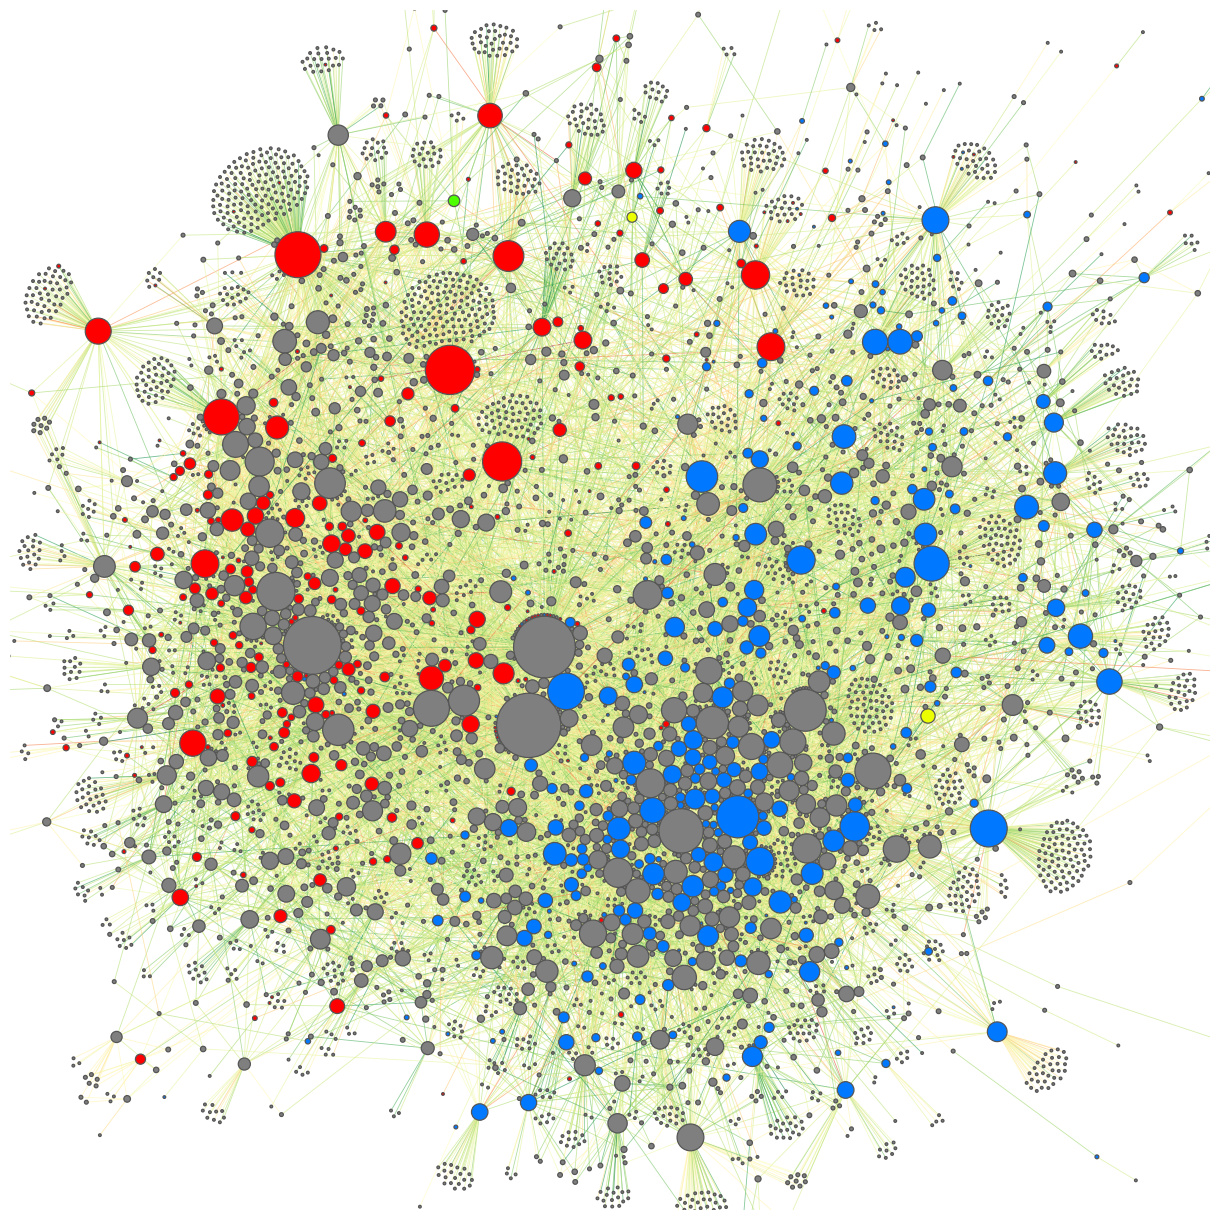

In [ ]:
from netwulf.tools import draw_netwulf

# Draw colored edges, which doesn't work in interactive mode
fig, ax = draw_netwulf(network_properties, figsize=12)
fig.show()

In [107]:
# Get only congress members graph
only_party_G = G.copy()
no_party = [k for k,v in G.nodes(data=True) if v.get("party") is None]
only_party_G.remove_nodes_from(no_party)
only_party_G = nx.DiGraph(only_party_G)
# Remove isolated nodes
isolated_nodes = list(nx.isolates(only_party_G))
only_party_G.remove_nodes_from(isolated_nodes)

In [108]:
network_properties, config = netwulf.visualize(only_party_G, plot_in_cell_below=False)
print('got data')

for link in network_properties['links']:
    src = link['source']   
    tgt = link['target'] 
    # Add avg sentiment back to link
    link['avg_sentiment'] = only_party_G[src][tgt]['avg_sentiment']

sents = [d['avg_sentiment'] for _,_,d in only_party_G.edges(data=True)]
cmap = cm.get_cmap('RdYlGn')
norm = mcolors.Normalize(vmin=min(sents), vmax=max(sents))

for link in network_properties['links']:
    s = link.get('avg_sentiment')
    rgba = cmap(norm(s))
    link['color'] = mcolors.to_hex(rgba)

# now instruct Netwulf to use your manual hexes
config['link_color_field'] = 'color'
# graph_data, config = netwulf.visualize(network_properties, config = config)

/opt/homebrew/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


got data


/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_44262/3246093713.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


/var/folders/pw/mnpmywp944s16f9v7t3n65tm0000gp/T/ipykernel_44262/729509020.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


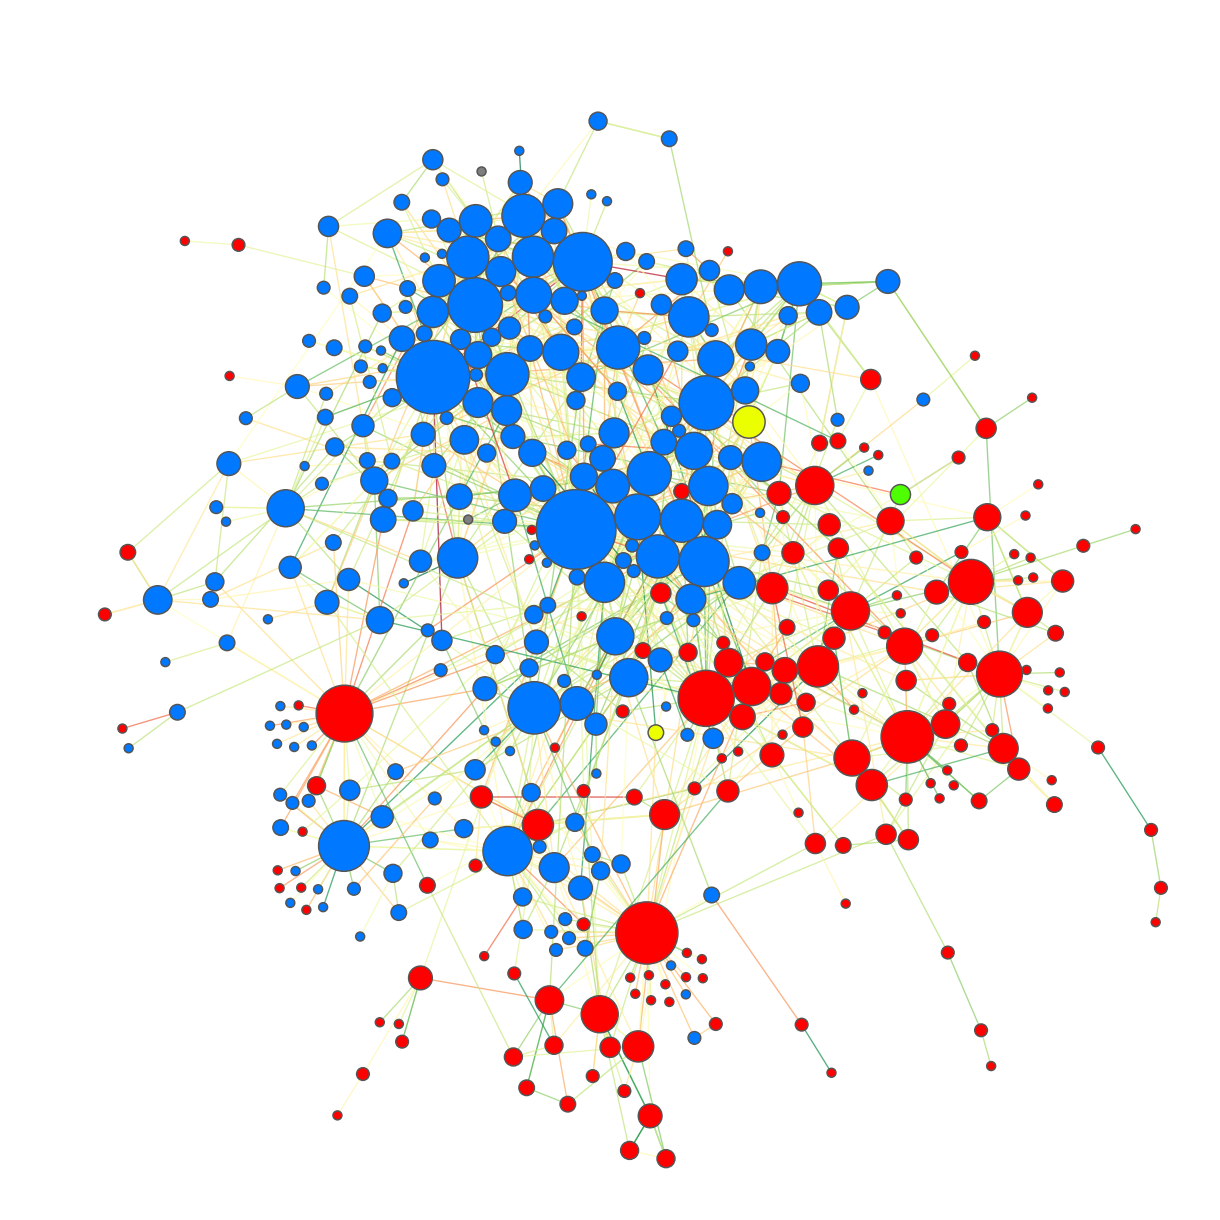

In [109]:
from netwulf.tools import draw_netwulf

# Draw colored edges, which doesn't work in interactive mode
fig, ax = draw_netwulf(network_properties, figsize=12)
fig.show()